In [1]:
import os
import sys
# sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')
sys.path.append('C:/Users/USER/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path + '\\ultils')
# os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import prince
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from matplotlib.font_manager import FontProperties

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *
from plots import *

# os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core_old import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

# myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
# sns.set(style="whitegrid", font=myfont.get_name())
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

c:\Users\USER\Desktop\TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [154]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',

    # 最初的值只有一種
    # '車輛撞擊部位大類別名稱-最初', 
    '車輛撞擊部位大類別名稱-其他',
    
    # 兩個相似且幾乎全部資料都一樣
    # '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',

    # 分析新增的
    # '事故類型及型態子類別名稱'
]
# select_lst = dataA1.columns

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

pass_A2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] == '人的狀態']
pass_A1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] == '人的狀態']

# drop
pass_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
pass_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)

pass_A2 = pass_A2[pass_A2['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']
pass_A1 = pass_A1[pass_A1['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']
pass_A2 = pass_A2[pass_A2['行動電話或電腦或其他相類功能裝置名稱'] != '不明']
pass_A1 = pass_A1[pass_A1['行動電話或電腦或其他相類功能裝置名稱'] != '不明']

C:\Users\USER\AppData\Local\Temp\ipykernel_34404\4023374890.py:57: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_34404\4023374890.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [155]:
# Concat
rbind_data = pd.concat([pass_A1, pass_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)
# rbind_data['速限_int'] = rbind_data['速限-第1當事者']
# rbind_data['年齡_int'] = rbind_data['當事者事故發生時年齡']

bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].cat.add_categories('未知')
rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].fillna('未知')

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

dummy_data: (3117, 114)


篩選掉未紀錄資料以及分類人的狀態以及車的狀態

由於人的狀態資料量已經很少，所以不進行下採樣

# Kmode

Index(['天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
       '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
       '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
       '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種',
       '車輛撞擊部位大類別名稱-其他'],
      dtype='object')
Best run was number 1
Best run was number 1
Best run was number 6
Best run was number 8
Best run was number 9
Best run was number 8
Best run was number 9
Best run was number 1
Best run was number 2


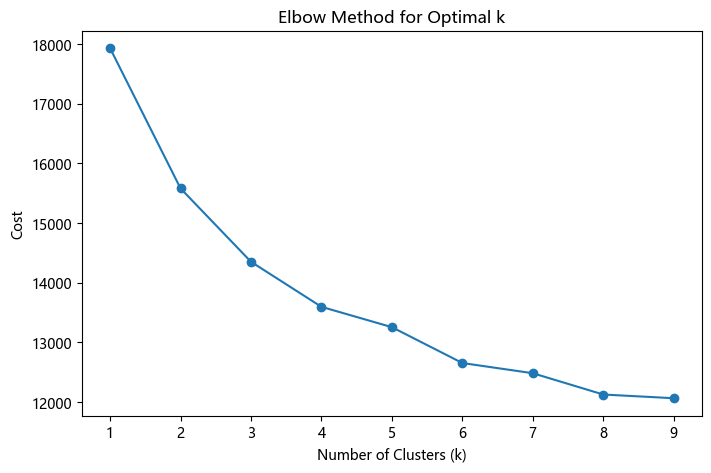

In [5]:
from kmodes.kmodes import KModes

data_for_kmode = rbind_data.drop(['死亡', '受傷'], axis=1)

print(data_for_kmode.columns)

cost = []
all_results = {}
K = range(1, 10)

for k in K:
    
    km = KModes(
    n_clusters=k, 
    init='Huang',
    verbose=1,
    random_state=42,
    n_jobs=5
    )

    labels = km.fit_predict(data_for_kmode)
    cost.append(km.cost_)
    all_results[k] = {
        'cost': km.cost_,
        'labels': labels,
        'centroids': km.cluster_centroids_
    }

optimal_k = K[cost.index(min(cost))]
optimal_result = all_results[optimal_k]

plt.figure(figsize=(8, 5))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()


# pd.Series(all_results[4]['labels']).value_counts()
# rbind_data['Cluster'] = all_results[4]['labels']

In [6]:
rbind_data['Cluster'] = all_results[4]['labels']

# MCA

In [ ]:
mca = prince.MCA(
    one_hot=False,
    n_components=12,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
)

mca.fit(data_to_map)
lens = mca.transform(data_to_map)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

In [ ]:
col_coordinate = mca.column_coordinates(data_to_map)

col_coordinate['dummy_index'] = range(len(col_coordinate))  # 為每個欄位分配索引

# Normalize the 'dummy_index' for mapping to colormap
norm = plt.Normalize(vmin=col_coordinate['dummy_index'].min(), vmax=col_coordinate['dummy_index'].max())
cmap = cm.viridis  # 選擇漸層色盤，例如 viridis, plasma, inferno 等

plt.figure(figsize=(20, 12))

plt.gca().set_facecolor('white')

# 繪製散點圖，顏色根據 dummy_index 映射
scatter = plt.scatter(
    col_coordinate[0],  # X coordinate
    col_coordinate[1],  # Y coordinate
    c=col_coordinate['dummy_index'],  # 使用索引作為顏色映射
    cmap=cmap,
    alpha=0.7
)

# Adding labels with colors matching the scatter plot
offset = 0.15
for i, label in enumerate(col_coordinate.index):
    plt.text(
        col_coordinate.iloc[i, 0],  # X coordinate
        col_coordinate.iloc[i, 1] + offset,  # Y coordinate
        str(label),  # 假設 label 包含中文
        fontsize=10,
        ha='center', 
        va='center',
        color=cmap(norm(col_coordinate.iloc[i]['dummy_index'])),  # 文字顏色與點顏色一致
        # rotation=30
    )

# Add colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label("Field Index (Gradient)", fontsize=12)

# Axes lines and grid
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
# plt.title("MCA", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.grid(True)

plt.show()

# Gridsearch

In [119]:
import pickle

detailed_results = []

for overlap in Overlap:
    silhouette_for_intervals = []

    for interval in Interval:
        try:
            print(f'overlap: {overlap}, interval: {interval}')

            mapper_algo = MapperAlgorithm(
                cover=CubicalCover(
                    n_intervals=interval,
                    overlap_frac=overlap / 10
                ),
                clustering=FailSafeClustering(
                    AgglomerativeClustering(
                        n_clusters=2,
                        linkage='ward'
                    )
                ),
                n_jobs=1
            )

            mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
            silhouette_for_intervals.append(mapper_info[1])

            result = {
                "overlap": overlap,
                "interval": interval,
                "silhouette": mapper_info[1],
                "mapper_info": mapper_info
            }

            detailed_results.append(result)

            filename = f"C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o{overlap}i{interval}.pkl"
            # filename = f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o{overlap}i{interval}.pkl"

            with open(filename, 'wb') as file:
                pickle.dump(result, file)

            print(f"Results saved to {filename}")

        except Exception as e:
            print(f"Error for overlap={overlap}, interval={interval}: {e}")

            continue

overlap: 4, interval: 8


Processing Clusters: 100%|██████████| 318/318 [00:04<00:00, 68.92it/s] 


In [7]:
# detailed_results_df = pd.DataFrame(detailed_results)

# output_file = 'C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/full_grid.pkl'
# with open(output_file, 'wb') as f:
#     pickle.dump(detailed_results_df, f)

output_file = 'C:/Users/USER/Desktop/TrafficTDApython/Version3/Gridsearch/Component12Pass/full_grid.pkl'

with open(output_file, 'rb') as f:
    detailed_results_df = pickle.load(f)

In [20]:
rbind_data['顯著特徵'] = rbind_data['道路型態子類別名稱'] + ',' + rbind_data['號誌-號誌動作名稱'] + ',' + rbind_data['天候名稱']
rbind_data['顯著特徵'].unique()

array(['直路,無號誌,晴', '直路,無號誌,陰', '三岔路,無號誌,晴', '四岔路,正常,晴', '三岔路,正常,晴',
       '直路,無號誌,雨', '四岔路,正常,雨', '四岔路,正常,陰', '直路,正常,陰', '直路,正常,晴',
       '彎曲路及附近,無號誌,晴', '多岔路,正常,晴', '直路,正常,雨', '四岔路,無號誌,雨', '三岔路,無號誌,陰',
       '四岔路,無號誌,陰', '四岔路,無號誌,晴', '其他,無號誌,晴', '直路,無號誌,霧或煙', '三岔路,無號誌,雨',
       '多岔路,正常,雨', '橋樑,無號誌,晴', '三岔路,正常,陰', '橋樑,無號誌,雨', '三岔路,正常,雨',
       '多岔路,無號誌,晴', '彎曲路及附近,無號誌,雨', '地下道,無號誌,晴', '其他,無號誌,雨', '多岔路,正常,陰',
       '坡路,正常,晴', '彎曲路及附近,無號誌,陰', '涵洞,無號誌,晴', '多岔路,無號誌,陰', '彎曲路及附近,正常,晴',
       '其他,正常,陰', '三岔路,無號誌,風', '直路,無動作,雨', '坡路,無號誌,雨', '其他,正常,晴',
       '其他,正常,雨', '休息站或服務區,無號誌,晴', '直路,無號誌,風', '圓環,無號誌,晴', '橋樑,無號誌,陰',
       '其他,無號誌,陰', '坡路,無號誌,陰', '多岔路,無號誌,雨', '高架道路,無號誌,陰', '圓環,正常,雨'],
      dtype=object)

Mapper plot created.
Data extracted.
Colors mapped using predefined mapping.


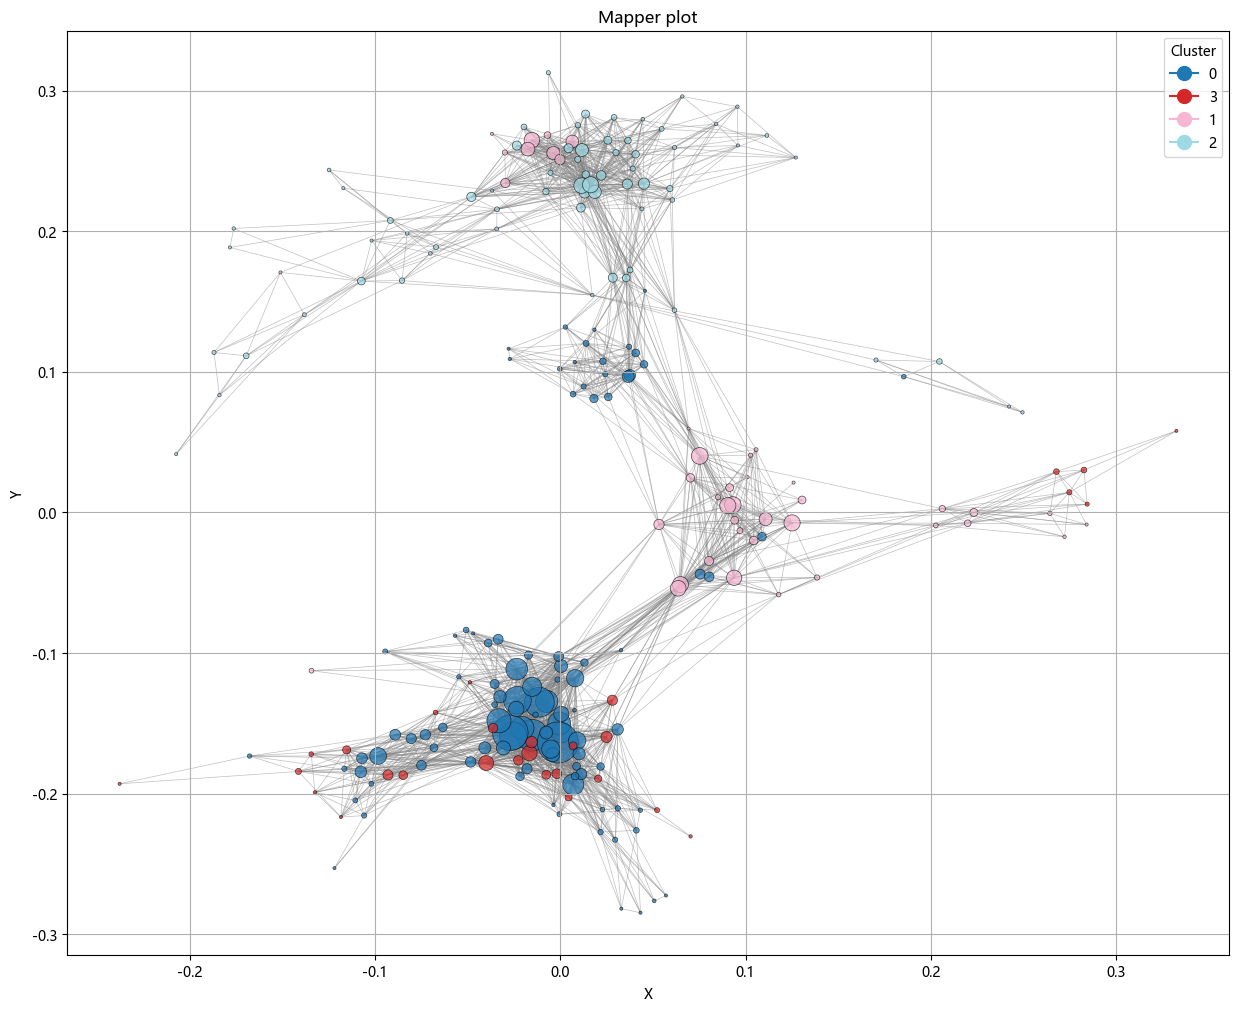

In [65]:
choose = 'Cluster'

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[33][0], rbind_data, seed=10)
mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
full_info = mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, size=4, threshold=0)
mapper_plotter.plot(choose, avg=False, set_label=True, size=100000)

In [ ]:
choose = 'Cluster'
# choose = '死亡'

unique_categories = rbind_data[choose].unique()
# unique_categories.sort()

for index in range(detailed_results_df.shape[0]):
    # 統一顏色
    color_palette = get_cmap("tab20", len(unique_categories))
    color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[index][0], 
                                rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, color_mapping_fixed, size=0)
    mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, 
                        set_label=False, size=100000,
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Pass/o{detailed_results_df['overlap'].iloc[index]}_i{detailed_results_df['interval'].iloc[index]}.png")

In [ ]:
for choose in lst:
    unique_categories = rbind_data[choose].dropna().unique()
    # 統一顏色
    color_palette = get_cmap("tab20", len(unique_categories))
    color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

    # mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[33][0],
    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[33][0], 
                                rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, color_mapping_fixed, size=0) # 篩選資料
    mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, 
                        set_label=True, size=100000, # 限制點的大小
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Pass/o4_i8_{choose}.png")

# Polygon

In [66]:
print(len(get_unique_ids(full_info)))

2975


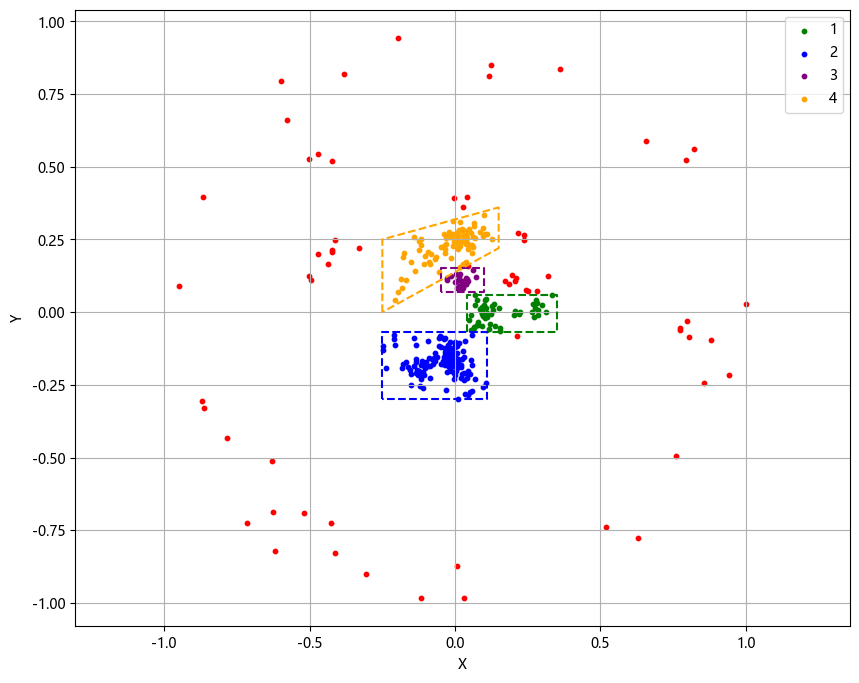

In [67]:
from shapely.geometry import Point, Polygon

rectangle1 = Polygon([(0.04, -0.07), (0.04, 0.06), (0.35, 0.06), (0.35, -0.07)])  # 矩形 1
rectangle2 = Polygon([(-0.25, -0.3), (-0.25, -0.07), (0.11, -0.07), (0.11, -0.3)])  # 矩形 2
rectangle3 = Polygon([(-0.05, 0.07), (-0.05, 0.15), (0.1, 0.15), (0.1, 0.07)]) 
rectangle4 = Polygon([(-0.25, 0), (-0.25, 0.25), (0.15, 0.36), (0.15, 0.22)]) 

# 限制會導致full_info的資料量減少
# filtered_full_info = full_info[full_info['size'] > 4]

# 檢查每個點是否在任意一個區塊內
inside_indices_1 = full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle1), axis=1)
inside_indices_2 = full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle2), axis=1)
inside_indices_3 = full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle3), axis=1)
inside_indices_4 = full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle4), axis=1)

label_0 = full_info[inside_indices_1]
label_1 = full_info[inside_indices_2]
label_2 = full_info[inside_indices_3]
label_3 = full_info[inside_indices_4]

# 提取區域內和區域外的數據
all_inside_indices = inside_indices_1 | inside_indices_2 | inside_indices_3 | inside_indices_4
outside_indices = ~all_inside_indices

label_out = full_info[outside_indices]

assert label_0.shape[0] + label_1.shape[0] 
+ label_2.shape[0] + label_3.shape[0] + label_out.shape[0] == full_info.shape[0]

# 繪製數據點和矩形區塊
plt.figure(figsize=(10, 8))
plt.scatter(label_0['x'], label_0['y'], label='1', color='green', s=10)
plt.scatter(label_1['x'], label_1['y'], label='2', color='blue', s=10)
plt.scatter(label_2['x'], label_2['y'], label='3', color='purple', s=10)
plt.scatter(label_3['x'], label_3['y'], label='4', color='orange', s=10)
plt.scatter(label_out['x'], label_out['y'], color='red', s=10)

# 繪製矩形區塊
for rect, color in zip([rectangle1, rectangle2, rectangle3, rectangle4], ['green', 'blue', 'purple', 'orange']):
    x, y = rect.exterior.xy
    plt.plot(x, y, color=color, linestyle='--')

# 圖形調整
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

In [68]:
print(rbind_data.shape)
print(len(get_unique_ids(full_info)))

(3117, 30)
2975


In [156]:
choose = '道路型態大類別名稱'

rbind_data['color_for_plot'] = pd.factorize(rbind_data[choose])[0]
mapper_plot = MapperLayoutInteractive(
    detailed_results_df['mapper_info'].iloc[33][0],
    colors=rbind_data['color_for_plot'].to_numpy(),
    cmap='jet',
    agg=most_common_encoded_label,
    dim=2,
    iterations=30,
    seed=10,
    width=400,
    height=400
)

x = vars(mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
y = vars(mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
threeDimData = pd.DataFrame({'x': x, 'y': y})

data_tuple = vars(mapper_plot._MapperLayoutInteractive__fig)['_data_objs'][1]['text']
data = []
for item in data_tuple:
    color = float(re.search(r'color: ([\d.]+)', item).group(1))
    node = int(re.search(r'node: (\d+)', item).group(1))
    size = int(re.search(r'size: (\d+)', item).group(1))
    data.append({'color': color, 'node': node, 'size': size})
component_info = pd.DataFrame(data)

full_info = pd.concat([component_info, threeDimData], axis=1)

mp_content_origin = vars(mapper_plot._MapperLayoutInteractive__graph)['_node']
mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index').reset_index()
mp_content.rename(columns={'index': 'node'}, inplace=True)

full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

In [157]:
# 獲取每個label的index
count_0 = get_unique_ids(label_0)
count_1 = get_unique_ids(label_1)
count_2 = get_unique_ids(label_2)
count_3 = get_unique_ids(label_3)
count_out = get_unique_ids(label_out)

full_0 = dummy_data.loc[count_0]
full_1 = dummy_data.loc[count_1]
full_2 = dummy_data.loc[count_2]
full_3 = dummy_data.loc[count_3]
full_out = dummy_data.loc[count_out]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_2) == full_2.shape[0]
assert len(count_3) == full_3.shape[0]
assert len(count_out) == full_out.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_2.shape[0] + full_3.shape[0] + full_out.shape[0])
print(dummy_data.shape[0])

3049
3117


In [158]:
print(full_0['死亡'].value_counts())
print(full_1['死亡'].value_counts())
print(full_2['死亡'].value_counts())
print(full_3['死亡'].value_counts())
print(full_out['死亡'].value_counts())

0    426
1      2
Name: 死亡, dtype: int64
0    1788
1      30
2       1
Name: 死亡, dtype: int64
0    115
1      1
Name: 死亡, dtype: int64
0    551
1     14
Name: 死亡, dtype: int64
0    118
1      3
Name: 死亡, dtype: int64


In [159]:
def get_train_test_data(input_data):
    input_data['y'] = input_data['死亡'].apply(lambda x: 2 if x >= 1 else 1)
    
    new_input_data = input_data.drop(columns=['受傷', '死亡'], inplace=False)
    
    X = new_input_data.drop(columns=['y'])
    y = new_input_data['y']

    return X, y

In [163]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler

def logistic_cm_gridsearch(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

    print("Original train class distribution:", dict(zip(*np.unique(y_train, return_counts=True))))

    smote = SMOTE(random_state=42, k_neighbors=3)
    enn = EditedNearestNeighbours(n_neighbors=3)
    smote_enn = SMOTEENN(smote=smote, enn=enn)
    X_resampled_train, y_resampled_train = smote_enn.fit_resample(X_train, y_train)

    print("Resampled train class distribution:", dict(zip(*np.unique(y_resampled_train, return_counts=True))))

    min_class_count = min(sum(y_test == 1), sum(y_test == 2))
    
    rus_test = RandomUnderSampler(sampling_strategy={1: min_class_count, 2: min_class_count}, random_state=42)
    X_resampled_test, y_resampled_test = rus_test.fit_resample(X_test, y_test)

    print("Resampled test class distribution:", dict(zip(*np.unique(y_resampled_test, return_counts=True))))

    model = LogisticRegression(solver='saga', max_iter=10000)
    
    parameters = {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100]
    }

    grid_search = GridSearchCV(model, parameters, cv=5, scoring='accuracy')
    grid_search.fit(X_resampled_train, y_resampled_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_resampled_test)

    conf_matrix = confusion_matrix(y_resampled_test, y_pred)
    accuracy = accuracy_score(y_resampled_test, y_pred)

    precision = precision_score(y_resampled_test, y_pred, average=None, zero_division=0)
    recall = recall_score(y_resampled_test, y_pred, average=None)
    f1 = f1_score(y_resampled_test, y_pred, average=None)

    metrics_df = pd.DataFrame({
        'Label': [f'Class_{i}' for i in range(len(precision))],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    return metrics_df, accuracy, conf_matrix

In [164]:
X0, y0 = get_train_test_data(full_0)
X1, y1 = get_train_test_data(full_1)
X2, y2 = get_train_test_data(full_2)
X3, y3 = get_train_test_data(full_3)
Xout, yout = get_train_test_data(full_out)
Xfull, yfull = get_train_test_data(dummy_data)

In [167]:
# matrix_out, score_out, cm_out = logistic_cm_gridsearch(Xout, yout)
# matrix_0, score_0, cm_0 = logistic_cm_gridsearch(X0, y0)
matrix_1, score_1, cm_1 = logistic_cm_gridsearch(X1, y1)
# matrix_2, score_2, cm_2 = logistic_cm_gridsearch(X2, y2)
matrix_3, score_3, cm_3 = logistic_cm_gridsearch(X3, y3)
matrix_full, score_full, cm_full = logistic_cm_gridsearch(Xfull, yfull)


Original train class distribution: {1: 1253, 2: 20}
Resampled train class distribution: {1: 1253, 2: 1207}
Resampled test class distribution: {1: 11, 2: 11}
Original train class distribution: {1: 388, 2: 7}
Resampled train class distribution: {1: 388, 2: 375}
Resampled test class distribution: {1: 7, 2: 7}
Original train class distribution: {1: 2139, 2: 42}
Resampled train class distribution: {1: 2139, 2: 2047}
Resampled test class distribution: {1: 16, 2: 16}


In [168]:
# print(cm_0)
print(cm_1)
# print(cm_2)
print(cm_3)
# print(cm_out)
print(cm_full)


[[11  0]
 [11  0]]
[[7 0]
 [7 0]]
[[16  0]
 [16  0]]
